In [1]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis, norm, gaussian_kde
from scipy.stats import t as studentst
from statsmodels.graphics.tsaplots import plot_acf
from arch.univariate import arch_model
from statsmodels.api import qqplot
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
plt.rc("figure", figsize=(16, 6))
plt.rc("savefig", dpi=90)
plt.rc("font", family="sans-serif")
plt.rc("font", size=14)

In [2]:
data = pd.read_csv("QRM-2021-cw1-data-a.csv", index_col=0)
data.index = pd.to_datetime(data.index)
data["log_return"] = np.log(data/data.shift(1))
r = data["log_return"].dropna().values

In [3]:

def hist_plot(r, n_bins, r_name, filename, dist="norm", qq=True):
    x_min = np.min(r)
    x_max = np.max(r)
    x_dt = (x_max-x_min)/n_bins
    N = len(r)

    x_aux = np.arange(start=x_min, stop=x_max+x_dt, step=x_dt)
    if dist == "norm":
        x_mean, x_std = norm.fit(r)
        y_aux = np.diff(norm.cdf(x_aux, x_mean, x_std)) * N
        fit_dist = norm
        dist_name = 'Normal'
    elif dist == "t":
        x_df, x_loc, x_scale = studentst.fit(r)
        y_aux = np.diff(studentst.cdf(x_aux, x_df, x_loc, x_scale)) * N
        fit_dist = studentst
        dist_name = 'Student-t'
    else:
        raise NameError("dist: norm, t")
    kde = gaussian_kde(r, bw_method="scott")
    y_kde = np.array([kde.integrate_box(x_aux[i], x_aux[i]+x_dt) for i in range(len(x_aux)-1)]) * N

    plt.figure()
    if qq:
        ax1 = plt.subplot(121)
    else:
        ax1 = plt.subplot(111)
    # hist
    ax1.hist(r, bins=n_bins, label="hist")
    ax1.set(title=f"{r_name} Frequency Histogram", ylabel="Frequency")
    # estimated normal/t distribution
    ax1.plot((x_aux+x_dt/2)[:-1], y_aux, lw=2, label=dist)
    # kernel density estimation
    ax1.plot((x_aux+x_dt/2)[:-1], y_kde, lw=2, linestyle="dashed", color="gray", label="KDE")
    ax1.legend()
    # QQ plot
    if qq:
        ax2 = plt.subplot(122)
        qqplot(r, fit_dist, fit=True, line="45", ax=ax2)
        ax2.set(title=f"{dist_name} QQ Plot of Standardized Residuals")
    plt.show()
    plt.savefig(f"{filename}.pdf", format='pdf')
    plt.close()


In [4]:
print("mean:", np.mean(r))
print("standard deviation:", np.std(r))
print("skewness:", skew(r))
print("kurtosis:", kurtosis(r, fisher=False))

mean: 9.865010921833606e-05
standard deviation: 0.012262550711910633
skewness: -0.16459535146317042
kurtosis: 7.730551426321576


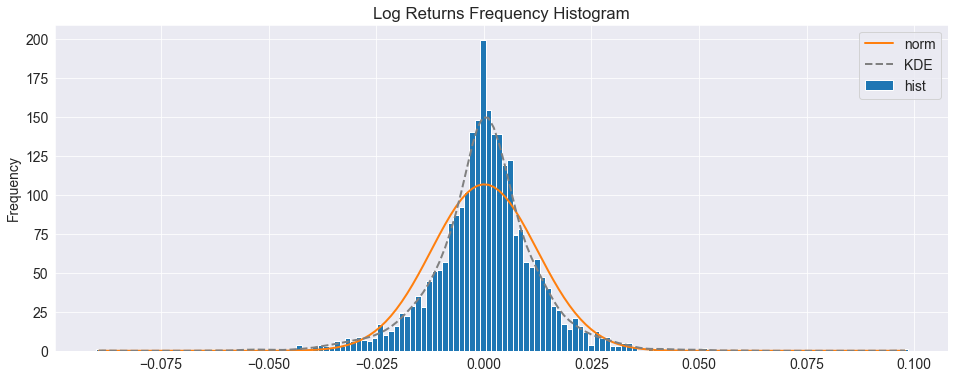

In [5]:
hist_plot(r, 150, "Log Returns", "1", qq=False)

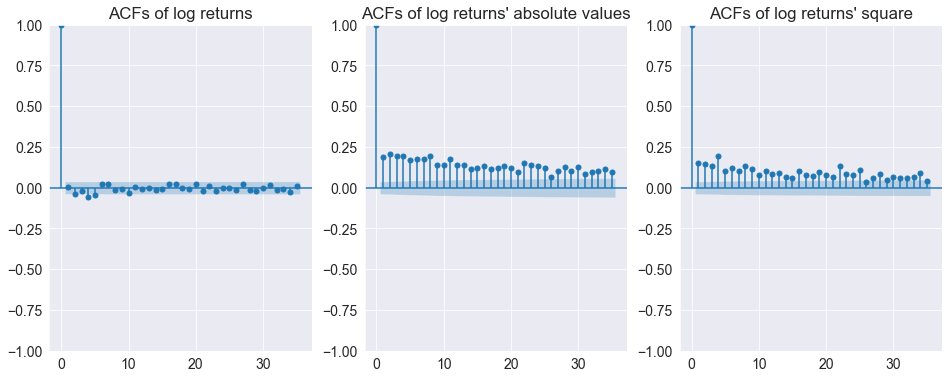

In [6]:
# log return
plt.figure()
ax1 = plt.subplot(131)
plot_acf(r, ax=ax1)
ax1.set(title="ACFs of log returns")
# absolute value
ax2 = plt.subplot(132)
plot_acf(np.abs(r), ax=ax2)
ax2.set(title="ACFs of log returns' absolute values")
# square
ax3 = plt.subplot(133)
plot_acf(r**2, ax=ax3)
ax3.set(title="ACFs of log returns' square")
plt.show()
plt.savefig("2.pdf", format='pdf')
plt.close()

In [7]:
r = data["log_return"].dropna()*100  # this is recomended by arch module, unless r is poorly scaled, which may affect convergence of the optimizer
am = arch_model(r, mean='Constant', vol='Garch', p=1, q=1, dist='Normal')
res = am.fit()
print(res.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 18228.11436172329
Iteration:      2,   Func. Count:     15,   Neg. LLF: 38387003790.22895
Iteration:      3,   Func. Count:     23,   Neg. LLF: 3979.4384446027266
Iteration:      4,   Func. Count:     29,   Neg. LLF: 28863.121200311623
Iteration:      5,   Func. Count:     37,   Neg. LLF: 4105.166591973065
Iteration:      6,   Func. Count:     44,   Neg. LLF: 3953.148746578887
Iteration:      7,   Func. Count:     50,   Neg. LLF: 3946.7140814744043
Iteration:      8,   Func. Count:     56,   Neg. LLF: 3946.3430704336033
Iteration:      9,   Func. Count:     61,   Neg. LLF: 3946.3424570164298
Iteration:     10,   Func. Count:     66,   Neg. LLF: 3946.3424562711043
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3946.3424562711043
            Iterations: 10
            Function evaluations: 66
            Gradient evaluations: 10
                     Constant Mean - GARCH Model Results        

<Figure size 1152x432 with 0 Axes>

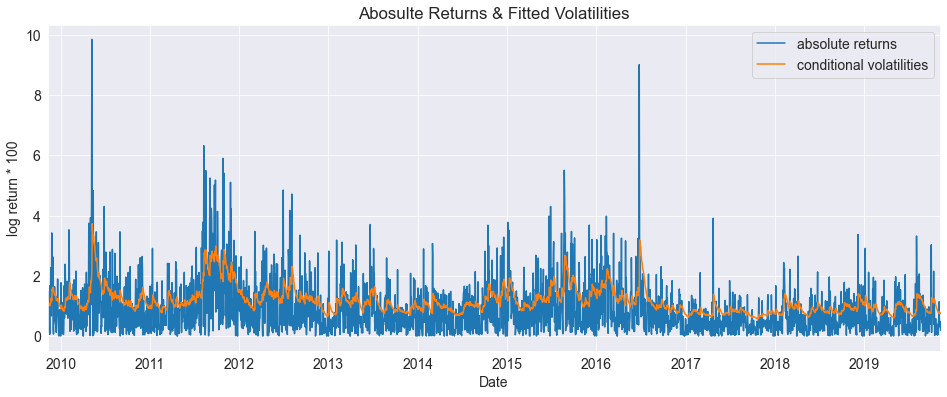

In [8]:
plt.figure()
df = pd.concat([r.abs(), res.conditional_volatility], axis=1)
df.columns = ["absolute returns", "conditional volatilities"]
df.plot()
plt.legend(loc='upper right')
plt.gca().set(title="Abosulte Returns & Fitted Volatilities", ylabel='log return * 100')
plt.show()
plt.savefig("3.pdf", format='pdf')
plt.close()

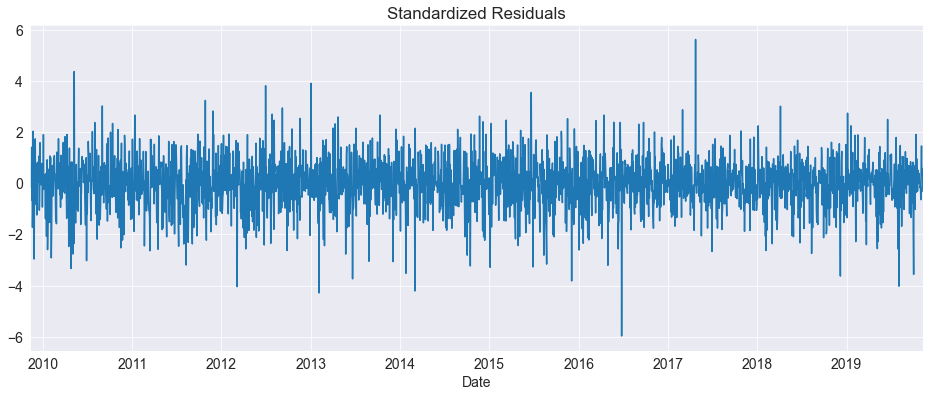

In [9]:
std_resid = res.std_resid
plt.figure()
std_resid.plot(title="Standardized Residuals")
plt.show()
plt.savefig("4-1.pdf", format='pdf')
plt.close()

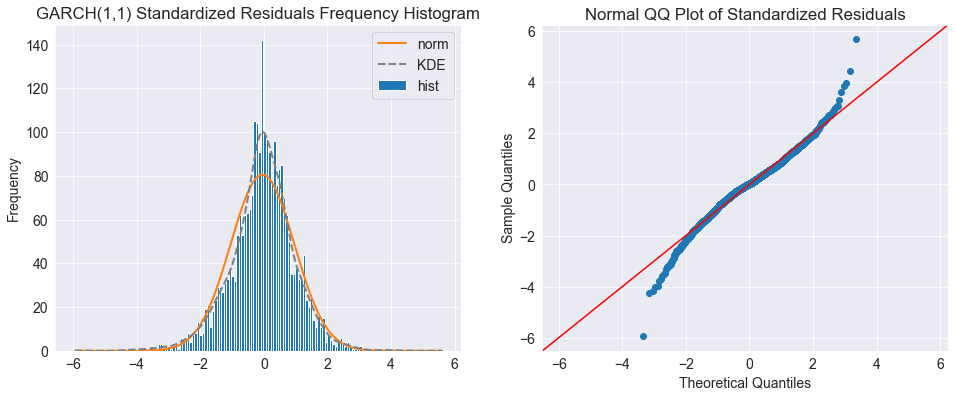

In [10]:
hist_plot(std_resid, 150, "GARCH(1,1) Standardized Residuals", "4-2")

In [11]:
print("AIC:", res.aic)
print("BIC:", res.bic)
print("\n\n")

AIC: 7900.684912542209
BIC: 7924.151801682756





<Figure size 1152x432 with 0 Axes>

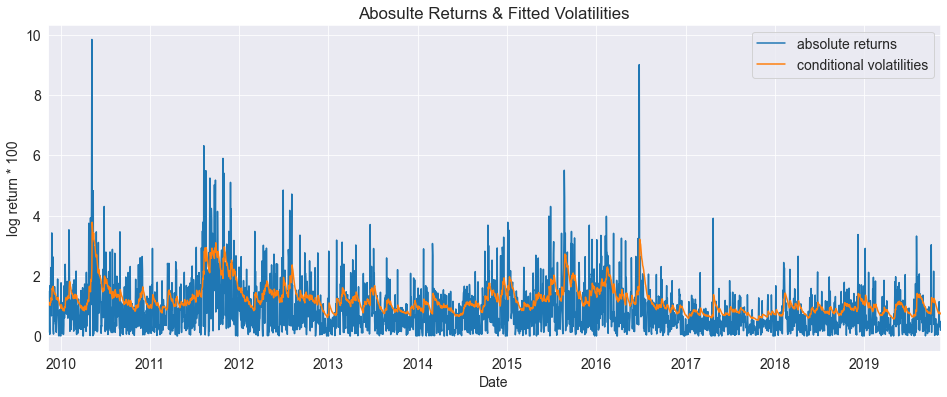

In [12]:
fit_vol = pd.read_csv("arma-garch-sigma.csv", header=0).values.flatten()
plt.figure()
df = pd.DataFrame()
df["absolute returns"] = r.abs()
df["conditional volatilities"] = fit_vol
df.plot()
plt.legend(loc='upper right')
plt.gca().set(title="Abosulte Returns & Fitted Volatilities", ylabel='log return * 100')
plt.show()
plt.savefig("5-1.pdf", format='pdf')
plt.close()

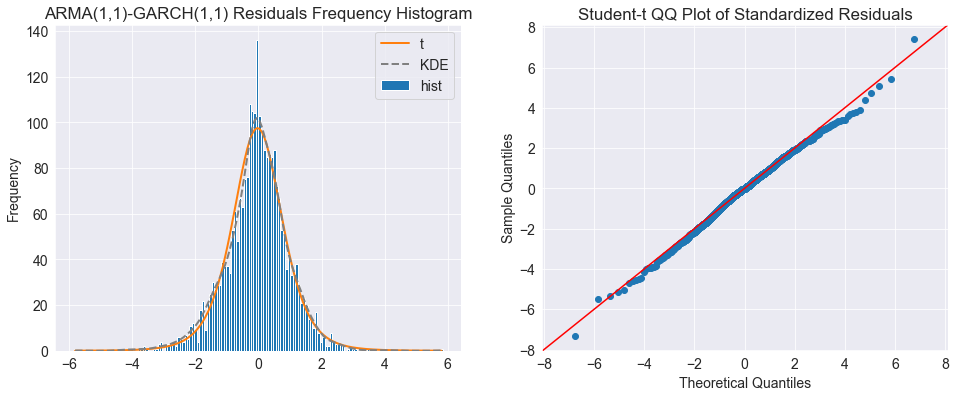

In [13]:
# use student t distribution to estimate residual
resid = pd.read_csv("arma-garch-resid.csv", header=0).values.flatten()
hist_plot(resid, 150, "ARMA(1,1)-GARCH(1,1) Residuals", "5-2", "t")

In [14]:
N = len(resid)
print("AIC:", 2.972748*N)  # interpret from R garch model
print("BIC:", 2.988489*N)
print("\n\n")

AIC: 7755.899532
BIC: 7796.967801





In [15]:
am = arch_model(r, mean='Constant', vol='Garch', p=1, q=1, dist='t')
res = am.fit()
print(res.summary())

Iteration:      1,   Func. Count:      7,   Neg. LLF: 66310.92108042672
Iteration:      2,   Func. Count:     17,   Neg. LLF: 67058.98953125274
Iteration:      3,   Func. Count:     27,   Neg. LLF: 6241.750810691134
Iteration:      4,   Func. Count:     34,   Neg. LLF: 6209.9586668720785
Iteration:      5,   Func. Count:     41,   Neg. LLF: 5817.321279740846
Iteration:      6,   Func. Count:     48,   Neg. LLF: 3872.6933390466056
Iteration:      7,   Func. Count:     55,   Neg. LLF: 6325.032687508786
Iteration:      8,   Func. Count:     63,   Neg. LLF: 3871.054861158885
Iteration:      9,   Func. Count:     69,   Neg. LLF: 3871.1394874555604
Iteration:     10,   Func. Count:     76,   Neg. LLF: 3871.0488871857997
Iteration:     11,   Func. Count:     82,   Neg. LLF: 3871.0488770075026
Iteration:     12,   Func. Count:     87,   Neg. LLF: 3871.0488770075035
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3871.0488770075026
            Iteration

<Figure size 1152x432 with 0 Axes>

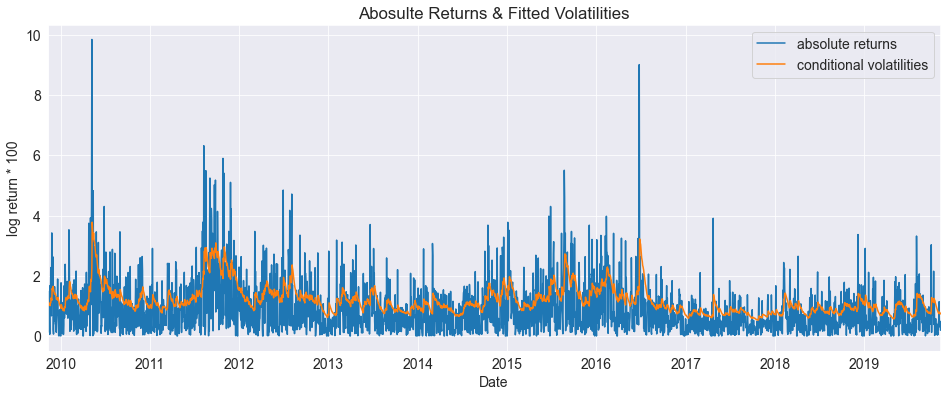

In [16]:
plt.figure()
df = pd.concat([r.abs(), res.conditional_volatility], axis=1)
df.columns = ["absolute returns", "conditional volatilities"]
df.plot()
plt.legend(loc='upper right')
plt.gca().set(title="Abosulte Returns & Fitted Volatilities", ylabel='log return * 100')
plt.show()
plt.savefig("6-1.pdf", format='pdf')
plt.close()

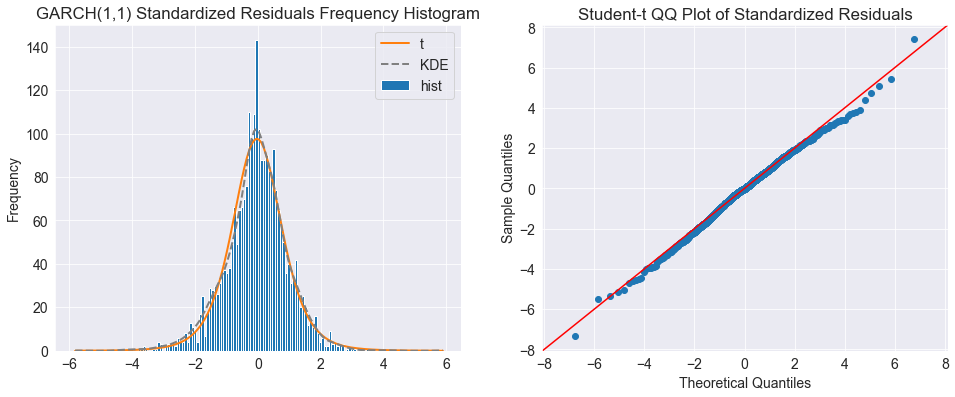

In [17]:
std_resid = res.std_resid
hist_plot(std_resid, 150, "GARCH(1,1) Standardized Residuals", "6-2", "t")

In [18]:
print("AIC:", res.aic)
print("BIC:", res.bic)

AIC: 7752.097754015005
BIC: 7781.431365440689
